In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as ticker
import pandas as pd
import glob
import re
# Statistics
from scipy.stats import norm
from scipy.special import factorial
from scipy.special import gammaln
import scipy.optimize as spo
# Parallel
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

In [2]:
# Matplotlib customize
plt.rcParams['figure.figsize'] = [6,5]
plt.rcParams['figure.dpi'] = 100

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.markerscale'] = 1.5
plt.rcParams['legend.borderpad'] = 0.6
plt.rcParams['legend.framealpha'] = 0.7

In [3]:
Data = []
Mass = np.array([])

for f in glob.glob('Data/*.csv'):
    #print(f)
    
    data = pd.read_csv(f,sep=',')
    Data.append(data)

    # Extraer los últimos tres números del nombre del archivo
    match = re.search(r'(\d{3})\.csv$', f)
    if match:
        Mass = np.append(Mass, float(match.group(1)))

# Emparejar los numeros con los dataframes
paired = list(zip(Mass,Data))

# Ordenar los pares segun las masas
Mass_sorted = sorted(paired, key=lambda x: x[0])

# Separar de nuevo los numeros y los dataFrames
Mass_sorted, Data = zip(*Mass_sorted)

# Numpy array
Mass = np.array(Mass_sorted)

print(Mass)

[100. 106. 112. 118. 124. 130. 136. 142. 148. 154. 160.]


In [4]:
# Reading channels
data = Data[4]
labels = list(data.keys())
n = np.array(data[labels[0]])
b = np.array(data[labels[1]])
s = np.array(data[labels[2]])
# Para significancia debes hacer n = s+b
N = n.shape[0]

In [5]:
def LogLikelihood(mu,n,b,s):
    
    lambda_ = mu*s + b
    
    log_likelihood = -lambda_ + n * np.log(lambda_) - gammaln(n+1)
    
    return log_likelihood

In [6]:
def GetJointLogLikelihood(mu,n,b,s):
    
    JointLog = 0.
    
    for c in range(N):
        JointLog += LogLikelihood(mu,n[c],b[c],s[c])
            
    return -JointLog

In [7]:
mu = np.linspace(0.,2.,20)
LogLike = GetJointLogLikelihood(mu,n,b,s)

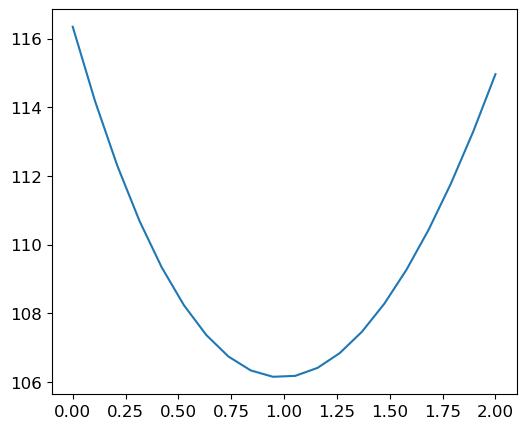

In [8]:
plt.plot(mu,LogLike)

In [9]:
# Minimizando el log-likelihood
mu0 = 1.
result = spo.minimize( GetJointLogLikelihood, mu0, args=(n,b,s), options={"disp":True}, method='Nelder-Mead' )

muhat = 0.
if result.success:
    print('Maximum found')
    muhat = result.x[0]
else:
    print('Maximum no found - SETPOI')

muhat

Optimization terminated successfully.
         Current function value: 106.135377
         Iterations: 10
         Function evaluations: 20
Maximum found


0.9865234375

In [10]:
def GetqmObs(mu,n,b,s):

    mu0 = 1.
    result = spo.minimize( GetJointLogLikelihood, mu0, args=(n,b,s), options={"disp":False}, method='Nelder-Mead' )
    
    muhat = result.x[0]
    
    qm = 0.
    
    for c in range(N):
        
        if muhat > 0.:
            qm += -2*(LogLikelihood(mu,n[c],b[c],s[c]) - LogLikelihood(muhat,n[c],b[c],s[c]))
        else:
            qm += 0.
            
    return qm

In [11]:
# Evaluamos la fortaleza de señal en mu=0
qmObs = GetqmObs(0.,n,b,s)
qmObs

20.416131414338338

In [12]:
def Getqm(mu,Null=True):
    
    Ntoys = np.zeros(N)
   
    for c in range(N):
        
        if Null:
            ntoy = np.random.poisson(b[c])
        else:
            ntoy = np.random.poisson(mu*s[c]+b[c])
          
        Ntoys[c] = ntoy
            
    return GetqmObs(mu,Ntoys,b,s)

In [13]:
def Sampler(mu,Ntoys = int(1e3)):
    
    q0 = np.zeros(Ntoys)

    for i in range(Ntoys):
        q0[i] = Getqm(mu,Null=True)
        
    return q0

In [14]:
q0 = Sampler(0.)

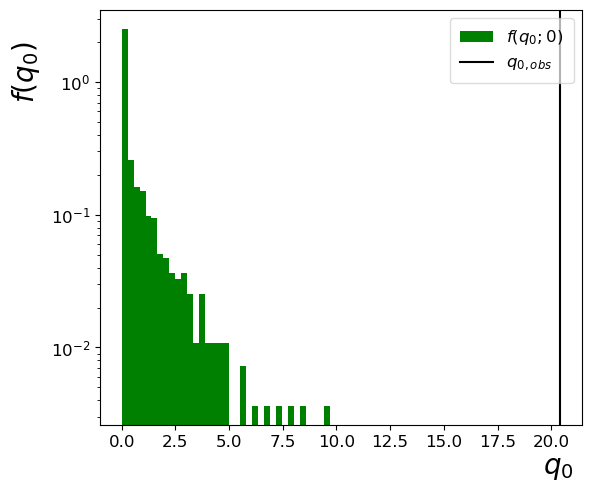

In [15]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(q0,bins=35,color='green',density=True,label=r'$f(q_{0};0)$')
ax.axvline(x=qmObs,color='k',label=r'$q_{0,obs}$')

# Label X
ax.set_xlabel(r'$q_{0}$')
ax.xaxis.set_label_coords(0.95,-0.07)

# Label Y
ax.set_ylabel(r'$f(q_{0})$')
ax.yaxis.set_label_coords(-0.12,0.85)

ax.set_yscale('log')

# Ajustar los márgenes automáticamente
plt.tight_layout()

#Legend
ax.legend(loc='upper right',bbox_to_anchor=(1,1),ncol=1,title='')

#
#plt.savefig('Distribution_q0.pdf')

In [16]:
def GetPValue(data,Qobs):

    count_above_threshold = np.sum( data >= Qobs )
    p_value = count_above_threshold / data.shape[0]

    return p_value

In [22]:
p0 = GetPValue(q0,qmObs)
print(p0)

0.0


In [23]:
def GetPvalue_for_data(i,data):

  #  print(data)
    labels = list(data.keys())
    n = np.array(data[labels[0]])
    b = np.array(data[labels[1]])
    s = np.array(data[labels[2]])
    # Si quiere significancia hacer n = s+b
    # Signal strength debe ser 0
    qmObs = GetqmObs(0,n,b,s)           
    q0  = Sampler(0.,Ntoys=int(30000))

    p0 = GetPValue(q0,qmObs)    
    
    return i,p0

In [24]:
def GetPvalue_Parallel(Data, num_processors=None):
    
    p_value = np.zeros_like(Mass)

    with ProcessPoolExecutor(max_workers=num_processors) as executor:

        futures = np.array([])

        # Crear las tareas (futuras) para cada valor de mu
        for i in range(len(Data)):
            futures = np.append(futures,executor.submit(GetPvalue_for_data, i, Data[i]))

        # Recolectar los resultados a medida que se completan
        for future in tqdm(as_completed(futures), total=len(futures)):
            i, p = future.result()
            p_value[i] = p

    return p_value

In [25]:
# Estructura de datos para guardar
MatrizDatos = np.zeros((Mass.shape[0],2))
MatrizDatos[:,0] = Mass
#MatrizDatos

In [26]:
p_value = GetPvalue_Parallel(Data,num_processors=8)
print(p_value)
MatrizDatos[:,1] = p_value

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [17:26<00:00, 95.13s/it]

[1.         1.         0.48553333 0.00256667 0.         0.00666667
 0.4515     1.         0.26536667 0.16303333 0.41726667]


In [27]:
DataFinal = pd.DataFrame(MatrizDatos)
DataFinal.columns = ['Mass','Local-p0']
DataFinal

,Mass,Local-p0
0,100.0,1.000000
1,106.0,1.000000
2,112.0,0.485533
3,118.0,0.002567
4,124.0,0.000000
5,130.0,0.006667
6,136.0,0.451500
7,142.0,1.000000
8,148.0,0.265367
9,154.0,0.163033


In [28]:
DataFinal.to_csv('LocalPvalue.csv',index=False)

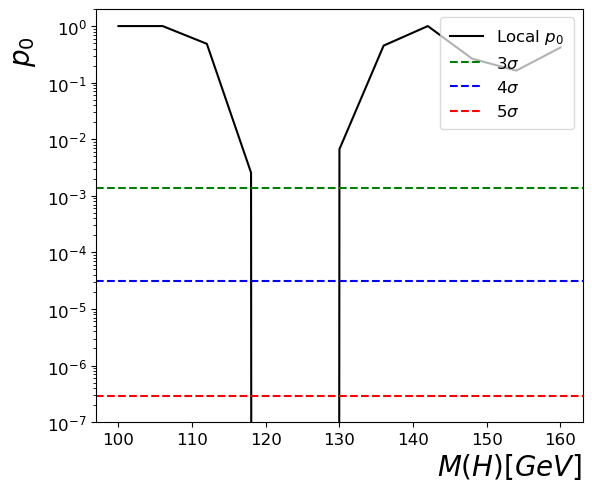

In [42]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(DataFinal['Mass'],DataFinal['Local-p0'],color='k',label=r'Local $p_{0}$')

#ax.axvline(x=qmObs,color='k',label=r'$q_{0,obs}$')

# Label X
ax.set_xlabel(r'$M(H)[GeV]$')
ax.xaxis.set_label_coords(0.85,-0.07)

# Label Y
ax.set_ylabel(r'$p_{0}$')
ax.yaxis.set_label_coords(-0.12,0.9)

ax.set_yscale('log')
ax.set_ylim(1e-7,2)

ax.axhline(y = 1-norm.cdf(3),ls='--',color='g',label=r'$3\sigma$')
ax.axhline(y = 1-norm.cdf(4),ls='--',color='b',label=r'$4\sigma$')
ax.axhline(y = 1-norm.cdf(5),ls='--',color='r',label=r'$5\sigma$')

# Ajustar los márgenes automáticamente
plt.tight_layout()

#Legend
ax.legend(loc='upper right',bbox_to_anchor=(1,1),ncol=1,title='')

#
plt.savefig('LocalP0.pdf')